In [1]:
import pandas as pd
import s3fs
import numpy as np

In [2]:
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "williamolivier"

FILE_PATH_S3_FVDEP = f"{MY_BUCKET}/diffusion/epci_6_clusters.csv"
with fs.open(FILE_PATH_S3_FVDEP, "rb") as file:
    epci_features = pd.read_csv(file)


In [3]:
# CALCUL EMISSIONS TOTALES 

pollution_au_km_flux_jaunes ={
    "Bus": 0.092, 
    "Métro/tram/transilien": 0.0045,
    "TER": 0.02693
}

pollution_au_km_flux_rouges = 0.097

# Dictionnaire avec les valeurs choisies pour chaque mode de TC en % de la distance parcourue en TC 

flux_jaunes_detail = {
    0 : { #Villes moyennes
        "Métro/tram/transilien": 0.2,
        "TER": 0.4,   
        "Bus": 0.4   
    },
    1 : { #Banlieue Paris
        "Métro/tram/transilien": 0.7,  
        "TER": 0.1,    
        "Bus": 0.2    
    },
    2 : { #Paris
        "Métro/tram/transilien": 0.8,  
        "TER": 0.1,   
        "Bus": 0.1   
    },
    3 : { #Autres
        "Métro/tram/transilien": 0, 
        "TER": 0.5,    
        "Bus": 0.5     
    },
    4 : { #Grandes villes
        "Métro/tram/transilien" : 0.5,
        "TER" : 0.2,
        "Bus" : 0.3
    },
    5 : { # Banlieue proche Paris
        "Métro/tram/transilien" : 0.7,
        "TER" : 0.1,
        "Bus" : 0.2
    }
}


# ici flux intra + moyenne des flux sortants et entrants 
epci_features["moyenne_flux_rouges"] = (
    epci_features['distance_intra_rouge'] +(
    epci_features['distance_entrant_<10km_rouge'] + 
    epci_features['distance_entrant_10<x<20km_rouge'] + 
    epci_features['distance_entrant_20<x<30km_rouge']  +
    epci_features['distance_entrant_30<x<40km_rouge'] + 
    epci_features['distance_entrant_40<x<50km_rouge']+ 
    epci_features['distance_entrant_50<x<infkm_rouge']  + 
    epci_features['distance_sortant_<10km_rouge']  + 
    epci_features['distance_sortant_10<x<20km_rouge']  + 
    epci_features['distance_sortant_20<x<30km_rouge'] +
    epci_features['distance_sortant_30<x<40km_rouge']+ 
    epci_features['distance_sortant_40<x<50km_rouge']+ 
    epci_features['distance_sortant_50<x<infkm_rouge'])/2)
    

epci_features['pollution_flux_rouges'] = epci_features['moyenne_flux_rouges'] * pollution_au_km_flux_rouges

epci_features["moyenne_flux_jaunes"] = (
    epci_features['distance_intra_jaune']+ (
    epci_features['distance_entrant_<10km_jaune']+ 
    epci_features['distance_entrant_10<x<20km_jaune'] + 
    epci_features['distance_entrant_20<x<30km_jaune'] +
    epci_features['distance_entrant_30<x<40km_jaune'] + 
    epci_features['distance_entrant_40<x<50km_jaune'] + 
    epci_features['distance_entrant_50<x<infkm_jaune'] + 
    epci_features['distance_sortant_<10km_jaune'] + 
    epci_features['distance_sortant_10<x<20km_jaune']  + 
    epci_features['distance_sortant_20<x<30km_jaune']+
    epci_features['distance_sortant_30<x<40km_jaune'] + 
    epci_features['distance_sortant_40<x<50km_jaune'] + 
    epci_features['distance_sortant_50<x<infkm_jaune'])/2)


for transport in ['Métro/tram/transilien', 'TER', 'Bus']:
    # Appliquer la répartition pour chaque mode de transport en fonction du cluster
    epci_features[f'distance_{transport}'] = epci_features['moyenne_flux_jaunes'] * \
        epci_features['cluster'].map(lambda cluster: flux_jaunes_detail.get(cluster, {}).get(transport, 0))

for transport in ['Métro/tram/transilien', 'TER', 'Bus']:
    # Calculer la pollution en multipliant la distance par les émissions par km pour chaque mode
    epci_features[f'pollution_{transport}'] = epci_features[f'distance_{transport}'] * pollution_au_km_flux_jaunes[transport]

epci_features['pollution_flux_jaunes'] = (
    epci_features['pollution_Métro/tram/transilien'] + epci_features['pollution_TER'] + 
    epci_features['pollution_Bus']) 

epci_features['pollution_totale'] = (
    epci_features['pollution_flux_rouges'] + epci_features['pollution_flux_jaunes'])


In [4]:
mauvais_eleves = []

for cluster_id in epci_features['cluster'].unique():
    # On sélectionne les lignes du cluster
    groupe = epci_features[epci_features['cluster'] == cluster_id]
    seuil = groupe['pollution_flux_rouges'].mean() + 2*groupe['pollution_flux_rouges'].std()
    mauvais = groupe[groupe['pollution_flux_rouges'] > seuil]
    mauvais_eleves.append(mauvais)

# On concatène tous les mauvais élèves en un seul DataFrame
mauvais_eleves_par_cluster = pd.concat(mauvais_eleves)

In [5]:
print(len(mauvais_eleves[0]))
print(len(mauvais_eleves[1]))
print(len(mauvais_eleves[2]))
print(len(mauvais_eleves[3]))
print(len(mauvais_eleves[4]))
print(len(mauvais_eleves[5]))
print(mauvais_eleves_par_cluster['NOM'])

13
4
0
0
1
1
245    ['Sempy', 'Beaurainville', 'Noyelles-lès-Humiè...
366    ['Videcosville', 'Pierreville', 'Gatteville-le...
472    ['Montreuil-sur-Mer', 'Camiers', 'Étaples', 'B...
549    ['Embres-et-Castelmaure', 'Fontjoncouse', 'Fit...
601    ['Aubigny', 'Gannay-sur-Loire', 'Bresnay', 'Pa...
689    ['Boucieu-le-Roi', 'Glun', 'Saint-Victor', "Po...
758    ['Gruissan', 'Leucate', 'Port-la-Nouvelle', 'G...
831    ['Saint-Pabu', 'Coat-Méal', 'Landéda', 'Le Dre...
840    ['Landivisiau', 'Bodilis', 'Commana', 'Saint-V...
841    ['Névez', 'Trégunc', 'Concarneau', 'Tourch', '...
842    ['Trégarantec', 'Guissény', 'Kerlouan', 'Le Fo...
844    ['Locquirec', 'Guerlesquin', 'Botsorhel', 'Loc...
882    ['Saint-Caprais-de-Bordeaux', 'Langoiran', 'Le...
45     ['Saint-Laurent-de-la-Salanque', 'Saint-Nazair...
830    ['Guipavas', 'Plouzané', 'Le Relecq-Kerhuon', ...
836    ['Rédené', 'Clohars-Carnoët', 'Saint-Thurien',...
843    ['Daoulas', 'Loperhet', 'Logonna-Daoulas', 'Sa...
262    ['Puteaux',

In [6]:
# cluster 1
print(mauvais_eleves_par_cluster['NOM'][270])

# cluster 4
print(mauvais_eleves_par_cluster['NOM'][262])

# cluster 1
print(mauvais_eleves_par_cluster['NOM'][45])
print(mauvais_eleves_par_cluster['NOM'][830])
print(mauvais_eleves_par_cluster['NOM'][836])
print(mauvais_eleves_par_cluster['NOM'][843])

# cluster 3
print(mauvais_eleves_par_cluster['NOM'][245])
print(mauvais_eleves_par_cluster['NOM'][366])
print(mauvais_eleves_par_cluster['NOM'][472])
print(mauvais_eleves_par_cluster['NOM'][549])
print(mauvais_eleves_par_cluster['NOM'][601])
print(mauvais_eleves_par_cluster['NOM'][689])
print(mauvais_eleves_par_cluster['NOM'][758])
print(mauvais_eleves_par_cluster['NOM'][831])
print(mauvais_eleves_par_cluster['NOM'][840])
print(mauvais_eleves_par_cluster['NOM'][841])
print(mauvais_eleves_par_cluster['NOM'][842])
print(mauvais_eleves_par_cluster['NOM'][844])
print(mauvais_eleves_par_cluster['NOM'][882])

['Claye-Souilly', 'Chennevières-lès-Louvres', 'Le Thillay', 'Villiers-le-Bel', 'Villeron', 'Puiseux-en-France', 'Épiais-lès-Louvres', 'Moussy-le-Neuf', 'Saint-Mard', 'Fontenay-en-Parisis', 'Le Mesnil-Aubry', 'Vémars', 'Fosses', 'Gonesse', 'Bonneuil-en-France', 'Villeneuve-sous-Dammartin', 'Louvres', 'Survilliers', 'Longperrier', 'Le Plessis-Gassot', 'Marly-la-Ville', 'Dammartin-en-Goële', 'Saint-Witz', 'Thieux', 'Bouqueval', 'Garges-lès-Gonesse', 'Moussy-le-Vieux', 'Goussainville', 'Rouvres', 'Arnouville', 'Compans', 'Gressy', 'Écouen', 'Juilly', 'Othis', 'Vaudherland', 'Le Mesnil-Amelot', 'Villeparisis', 'Mauregard', 'Mitry-Mory', 'Sarcelles', 'Roissy-en-France']
['Puteaux', 'Nanterre', 'Vaucresson', 'Saint-Cloud', 'Neuilly-sur-Seine', 'Courbevoie', 'La Garenne-Colombes', 'Rueil-Malmaison', 'Garches', 'Levallois-Perret', 'Suresnes']
['Saint-Laurent-de-la-Salanque', 'Saint-Nazaire', 'Pézilla-la-Rivière', "Espira-de-l'Agly", 'Canet-en-Roussillon', 'Le Barcarès', 'Sainte-Marie-la-Mer', '

In [7]:
mauvais_eleves_par_cluster['cluster']

245    3
366    3
472    3
549    3
601    3
689    3
758    3
831    3
840    3
841    3
842    3
844    3
882    3
45     0
830    0
836    0
843    0
262    5
270    1
Name: cluster, dtype: int64

In [8]:
# Le code ne s'exécute pas ici

# print(plot_pollution_par_cluster(mauvais_eleves_par_cluster, cluster_id=3))
# print(plot_pollution_par_cluster(mauvais_eleves_par_cluster, cluster_id=0))
# print(plot_pollution_par_cluster(mauvais_eleves_par_cluster, cluster_id=5))
# print(plot_pollution_par_cluster(mauvais_eleves_par_cluster, cluster_id=1))

## Simulations politiques de décarbonation 

In [9]:
# Scénario 1 : Electrification des véhicules 

# Hypothèse d'électrification possible par cluster
part_electrique_dict = {
    0: 0.3,  # Villes moyennes
    1: 0.4,  # Banlieue Paris
    2: 0.6,  # Paris
    3: 0.2,  # Autres / ruraux
    4: 0.4,  # Grandes villes
    5: 0.5   # Banlieue proche Paris
}

def scenario_electrification_par_cluster(df, part_electrique_dict, facteur_thermique=0.097, facteur_electrique=0.02):
    df = df.copy()

    def get_facteur_moyen(cluster):
        part_elec = part_electrique_dict.get(cluster, 0)
        return part_elec * facteur_electrique + (1 - part_elec) * facteur_thermique

    # Appliquer le facteur d'émission moyen par cluster
    df['facteur_moyen'] = df['cluster'].apply(get_facteur_moyen)

    # Calcul des émissions simulées
    df['pollution_flux_rouges_simu'] = df['moyenne_flux_rouges'] * df['facteur_moyen']
    df['pollution_totale_simu'] = df['pollution_flux_rouges_simu'] + df['pollution_flux_jaunes']
    df['gain_kg_CO2'] = df['pollution_totale'] - df['pollution_totale_simu']
    df['pollution_flux_jaunes_simu'] = df['pollution_flux_jaunes'] # les flux jaunes ne changent pas ici

    
    return df

df_simu_elec = scenario_electrification_par_cluster(mauvais_eleves_par_cluster, part_electrique_dict)

In [10]:
# Scénario 2 : Report partiel sur les transports en commun (création de nouvelles lignes, augmentation fréquence,etc)

def scenario_report_vers_TC(df, part_reportee=0.2):
    df = df.copy()

    # Distance transférée de la voiture vers le TC
    distance_reportee = df['moyenne_flux_rouges'] * part_reportee
    df['moyenne_flux_rouges_simu'] = df['moyenne_flux_rouges'] * (1 - part_reportee)

    # Nouvelle pollution des flux rouges (voiture)
    df['pollution_flux_rouges_simu'] = df['moyenne_flux_rouges_simu'] * pollution_au_km_flux_rouges

    # Pollution ajoutée côté TC
    for transport in ['Métro/tram/transilien', 'TER', 'Bus']:
        part_transport = df['cluster'].map(lambda cluster : flux_jaunes_detail.get(cluster, {}).get(transport, 0))
        df[f'distance_{transport}_ajoutee'] = distance_reportee * part_transport
        df[f'pollution_{transport}_ajoutee'] = df[f'distance_{transport}_ajoutee'] * pollution_au_km_flux_jaunes[transport]

    # Nouvelle pollution totale des flux jaunes
    df['pollution_flux_jaunes_simu'] = (
        df['pollution_flux_jaunes'] +
        df['pollution_Métro/tram/transilien_ajoutee'] +
        df['pollution_TER_ajoutee'] +
        df['pollution_Bus_ajoutee']
    )

    # Recalcul total
    df['pollution_totale_simu'] = df['pollution_flux_rouges_simu'] + df['pollution_flux_jaunes_simu']
    df['gain_kg_CO2'] = df['pollution_totale'] - df['pollution_totale_simu']

    return df

df_simu_report_TC = scenario_report_vers_TC(mauvais_eleves_par_cluster, part_reportee=0.2)

In [11]:
# Visualisation graphique des gains réalisés par un scénario 
def plot_repartition_flux_avant_apres(df, label_col='SIREN_EPCI', titre_scenario="scénario"):
    import numpy as np
    import matplotlib.pyplot as plt

    df = df.copy()

    for col in ['pollution_flux_rouges', 'pollution_flux_rouges_simu', 
                'pollution_flux_jaunes', 'pollution_flux_jaunes_simu', 'cluster', 'gain_kg_CO2']:
        if col not in df.columns:
            raise ValueError(f"Colonne manquante : {col}")

    gain_total_tonnes = df['gain_kg_CO2'].sum() / 1e3
    print(f"Gain total estimé : {gain_total_tonnes:.2f} tonnes de CO₂ évitées")

    noms = df[label_col].astype(str) + " (" + df['cluster'].astype(str) + ")"
    x = np.arange(len(df))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, max(6, len(df) * 0.4)))
    
    ax.bar(x - width/2, df['pollution_flux_rouges'], width, label='Flux rouges – Avant', color='#d73027')
    ax.bar(x - width/2, df['pollution_flux_jaunes'], width, 
           bottom=df['pollution_flux_rouges'], label='Flux jaunes – Avant', color='#fee08b')

    ax.bar(x + width/2, df['pollution_flux_rouges_simu'], width, label='Flux rouges – Après', color='#a50026')
    ax.bar(x + width/2, df['pollution_flux_jaunes_simu'], width, 
           bottom=df['pollution_flux_rouges_simu'], label='Flux jaunes – Après', color='#d9ef8b')
    
    ax.set_ylabel("Émissions de CO₂ (kg)")
    ax.set_title(f"Répartition des émissions – {titre_scenario}")
    ax.set_xticks(x)
    ax.set_xticklabels(noms, rotation=45, ha='right')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

Gain total estimé : 1578.64 tonnes de CO₂ évitées


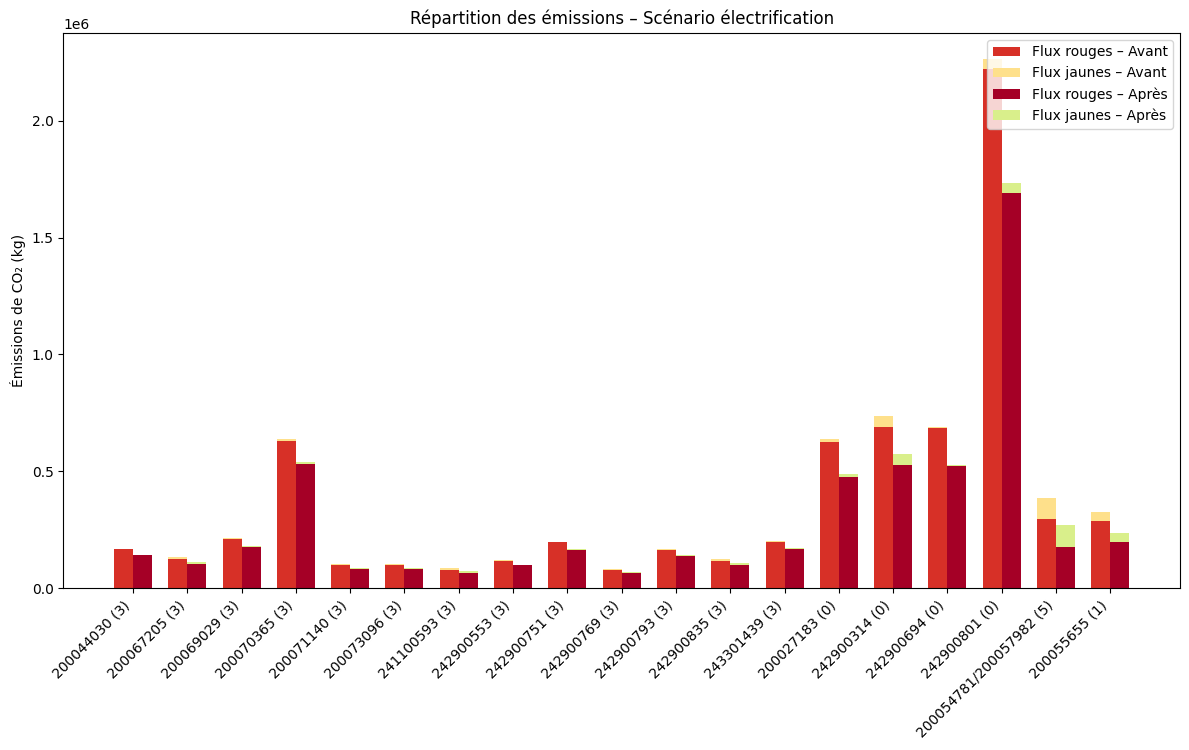

Gain total estimé : 687.58 tonnes de CO₂ évitées


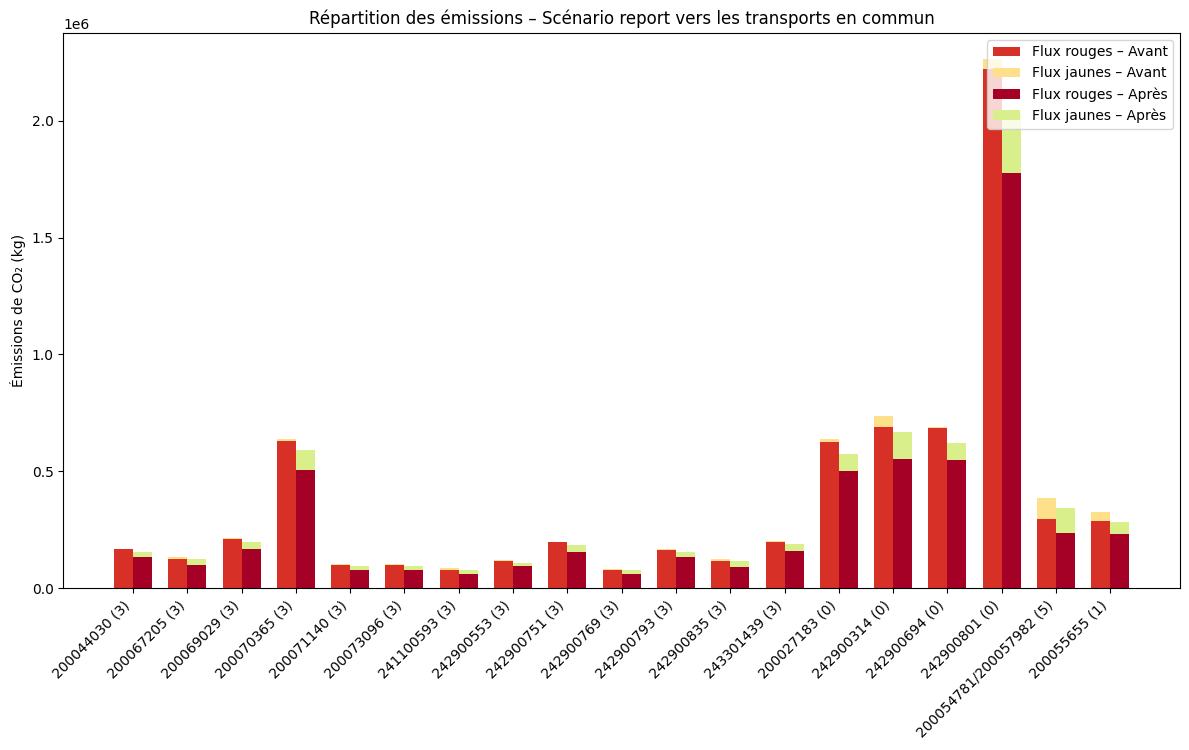

In [12]:
plot_repartition_flux_avant_apres(df_simu_elec, label_col='SIREN_EPCI', titre_scenario='Scénario électrification')
plot_repartition_flux_avant_apres(df_simu_report_TC, label_col='SIREN_EPCI', titre_scenario='Scénario report vers les transports en commun')

# BONUS : étude socio

In [13]:
from script import df_dossier_complet_brut
from script import df_meta_dossier_complet_brut

/home/onyxia/work/statapp/script.py:19: DtypeWarning: Columns (1,1687,1688) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/work/statapp/script.py:24: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/work/statapp/script.py:34: DtypeWarning: Columns (1,2,3,4,14,15,16,18,22,24,27,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mobpro_brut = pd.read_csv(file)
/home/onyxia/work/statapp/script.py:142: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  contours_comm["centroid"] = contours_comm.geometry.centroid
/home/onyxia/work/statapp/script.py:151: UserWarning: Geometry is in a geographic CRS. Results from 'centroid'

antully: (46.89232199838103, 4.402852764409862)
le tremblay-omonville: (49.12081156432765, 0.9143802127565656)
vaux-lès-mouzon: (49.60389494206806, 5.136483053287144)
anchenoncourt-et-chazel: (47.8616809003776, 6.11534440434135)
culoz-béon: (45.85633732729717, 5.772905566192263)
domèvre-sur-avière: (48.22223470040439, 6.388423941842605)
bernoy-le-château: (49.32120314158208, 3.3070156677330558)
videcosville: (49.566672646936, -1.3714795795608266)
saint-agrève: (45.00542393638767, 4.413096930429594)
le bourg-d'oisans: (45.0340588974907, 6.032836629436181)


In [14]:
df_meta_dossier_complet_brut['THEME'].unique()

array(['Évolution et structure de la population',
       'Couples - Familles - Ménages', 'Logement', 'Diplômes - Formation',
       'Population active, emploi et chômage au sens du recensement',
       "Caractéristiques de l'emploi au sens du recensement",
       'Naissances et décès domiciliés',
       'Revenus et pauvreté des ménages',
       "Salaires et revenus d'activité",
       'Caractéristiques des établissements',
       'Démographie des entreprises', 'Tourisme', nan], dtype=object)

In [15]:
var_socio = ["MED21","TP6021","D121","D921","RD21","SNHM22"]

In [16]:
df_meta_dossier_complet_brut.loc[df_meta_dossier_complet_brut['COD_VAR'].isin(var_socio)]

,Unnamed: 0,COD_VAR,LIB_VAR,LIB_VAR_LONG,COD_MOD,LIB_MOD,TYPE_VAR,LONG_VAR,THEME,SOURCE
1544,1544,MED21,Médiane du niveau vie (€),Médiane du niveau de vie (€),NaN,NaN,CHAR,5,Revenus et pauvreté des ménages,"Insee-DGFiP-Cnaf-Cnav-Ccmsa, Fichier localisé ..."
1546,1546,TP6021,Taux de pauvreté-Ensemble (%),Taux de pauvreté-Ensemble (%),NaN,NaN,CHAR,4,Revenus et pauvreté des ménages,"Insee-DGFiP-Cnaf-Cnav-Ccmsa, Fichier localisé ..."
1566,1566,D121,1er décile du niveau de vie (€),1er décile du niveau de vie (€),NaN,NaN,CHAR,5,Revenus et pauvreté des ménages,"Insee-DGFiP-Cnaf-Cnav-Ccmsa, Fichier localisé ..."
1567,1567,D921,9e décile du niveau de vie (€),9e décile du niveau de vie (€),NaN,NaN,CHAR,6,Revenus et pauvreté des ménages,"Insee-DGFiP-Cnaf-Cnav-Ccmsa, Fichier localisé ..."
1568,1568,RD21,Rapport interdécile 9e décile/1er décile,Rapport interdécile 9e décile/1er décile,NaN,NaN,CHAR,4,Revenus et pauvreté des ménages,"Insee-DGFiP-Cnaf-Cnav-Ccmsa, Fichier localisé ..."
1569,1569,SNHM22,Salaire net horaire moyen en 2022 (€),Salaire net horaire moyen en 2022 (€),NaN,NaN,NUM,16,Salaires et revenus d'activité,"Insee, Bases Tous salariés, fichier salariés a..."


In [17]:
import numpy as np
df_dossier_complet_brut[var_socio] = df_dossier_complet_brut[var_socio].replace('s', np.nan)
df_dossier_complet_brut[var_socio].isna().mean() * 100


MED21     10.507816
TP6021    87.400337
D121      84.682651
D921      84.682651
RD21      84.682651
SNHM22    84.374018
dtype: float64

On retient MED21 qui a le moins de valeurs manquantes

In [18]:
df_dossier_complet_brut['MED21']

0        25820
1        24480
2        21660
3        24610
4        24210
         ...  
34988      NaN
34989      NaN
34990      NaN
34991      NaN
34992      NaN
Name: MED21, Length: 34993, dtype: object